# Restricted Boltzmann Machine - MNIST

!!!!!!!!! DA METTERE QUI I NOSTRI NOMI E NUMERI DI MATRICOLATA DA COPIARE DAL NOTEBOOK PRECEDENTE (NON AVEVO VOGLIA)

# A. Setting

### Imports

In [8]:
import sys, datetime
import itertools as it
import scipy
import itertools
import tqdm
import os
import glob
import numba
from collections import Counter
from numba import njit, prange, vectorize
import ast
import pandas as pd

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

### Get data

In [ ]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='liac-arff')
print(X_original.shape)

(70000, 784)


### Parameters (original version)

In [22]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3
D = 784
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=False
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

In [23]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0, 0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05, 0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


### Select data, and digitalize them two levels

('0', '1', '2')
first 10 MNIST data points


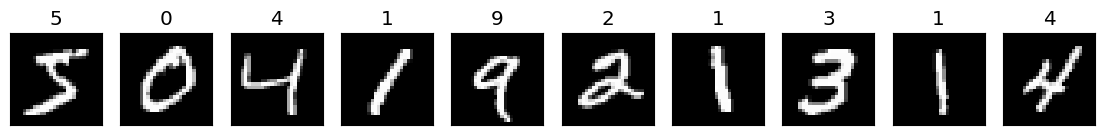

first 10 MNIST-3 data points


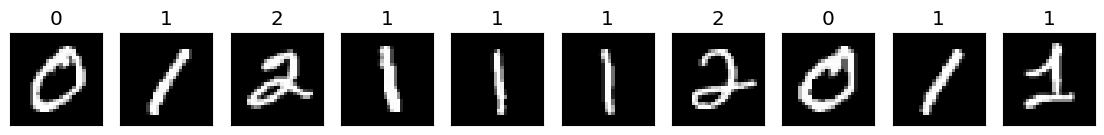

first 10 MNIST-3 data points, binarized


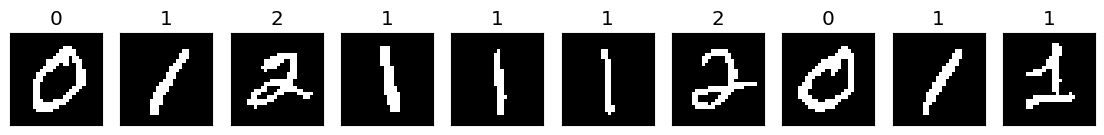

each of Nd=21770 data has D=784 bits


In [24]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "grey"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()
            
def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    #print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[:Ndigit]
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')



### Plotting data stats

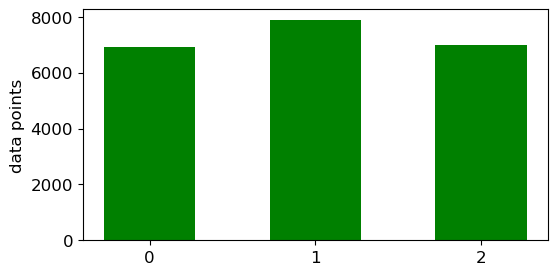

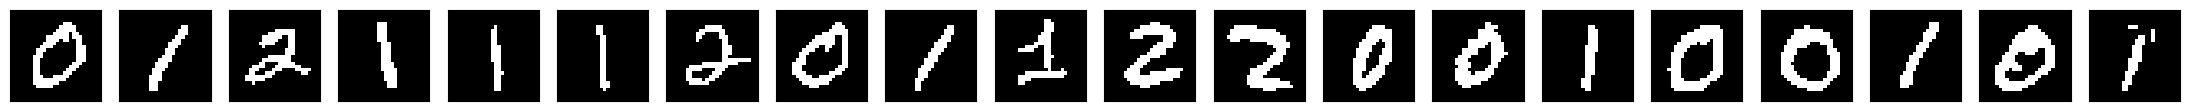

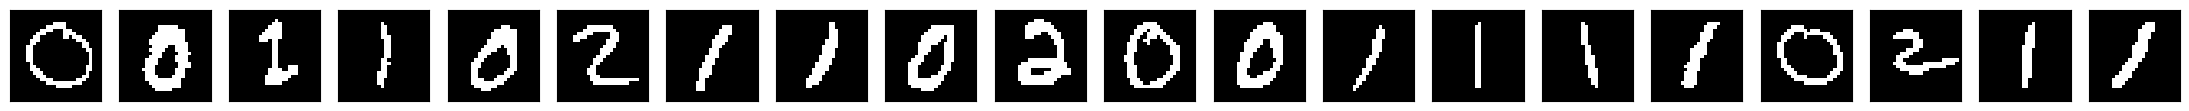

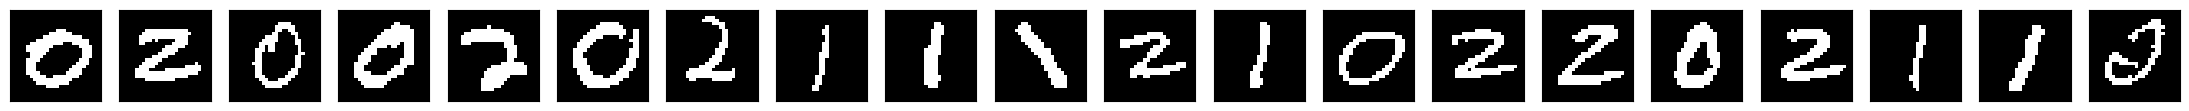

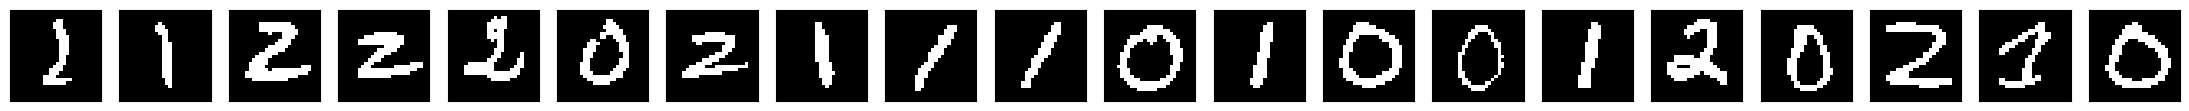

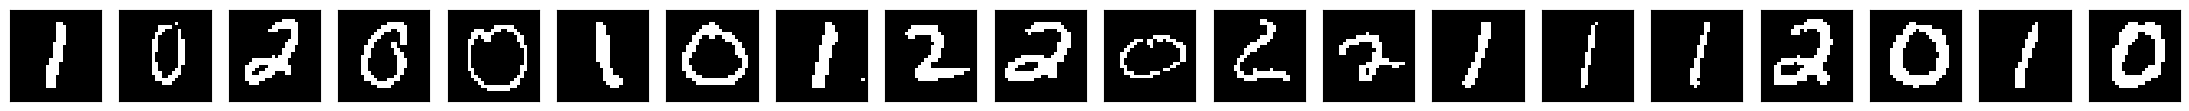

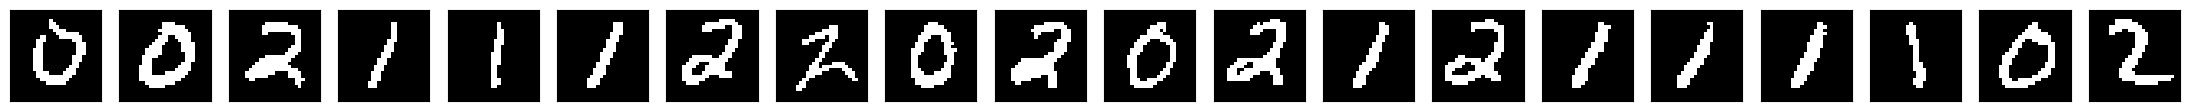

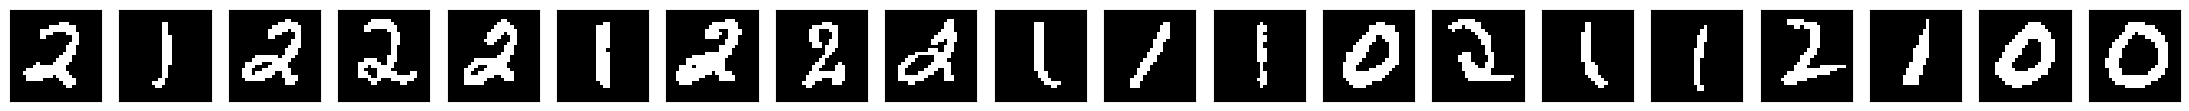

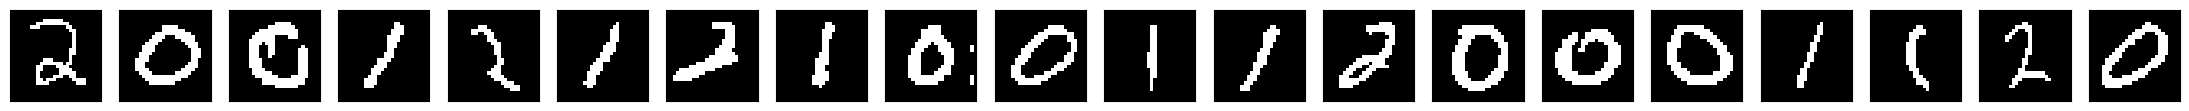

In [25]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

### Plot weights

In [26]:
def plot_weights_bias(wE, bE, epoch, L, side=0,cols=0,thr=0,s=1.5, title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


### Load Data

In [27]:
#return an array (nummber of trials for the same model) of arrays (these are the numpy arrays of "what" see below)
#what: a,b,w,logL(train),logLvalid
def LoadArrays(what, hp, Folder):

    variable_fileName = FileName(what, hp, FolderName=Folder, index = "*")
    # using * cause we can have more than one file (only difference time when was computed)
    filenames = variable_fileName[:-9] # [:-9] is to delete   _None.npy   at the place of time
    files = sorted(glob.glob(filenames))
    
    arrays = []
    
    for f in files:
        array = np.load(f)
        arrays.append(array)
    return arrays

In [28]:
def LoadData(WhichData = None, WhichFolder = None, WhichModel = None,  KFold = False):

   if KFold == False:
      data_FileList = glob.glob(f"{WhichFolder}/{WhichData}_*") 

      # Load all files into a dictionary
      data = {fname: np.load(fname) for fname in data_FileList}

      #return only the values of the dictionary
      return data
   
   elif KFold:
      dataF = glob.glob(f"{WhichModel}_*") 
      data = [np.load(fname) for fname in dataF]

      #Returns the only element present with the same name
      return data[0]


### Saving file

In [29]:
def FileName(label, hp, FolderName, KFold = False, index = 0, time = None):
   #Label might be: a, b or w, logL
   #hyperparam: [#-if-digits, #-of-hidden-var, CDnumber, optimizr, l_rate_in, l_rate_fin, epochs, gamma, POTTS, SPINS ]

   fname = f'{FolderName}/{label}_RBM_Ndig{hp['Ndigit']}_L{hp['L']}_Nt{hp['Nt']}_Opt{hp['Opt']}_lrate{hp['l_rate_in']:.2f}-{hp['l_rate_fin']:.2f}_Ep{hp['epochs']}_Mini{hp['mini']}'
   if hp['gamma'] > 0: fname = fname + f'_reg{hp['gamma']:.3f}'
   if hp['POTTS']: fname = fname + f'_MetPOTTS'
   if hp['SPINS']: fname = fname + f'_MetSPINS'
   if hp['POTTS']==False and hp['SPINS']==False: fname = fname + f'_MetBERN'
   fname = fname + f'__{index}'

   if KFold == False:
      fname = fname + f'_{time}' + '.npy'

   return fname

def SaveFile(label, hp, data, FolderName, time, index = 0):
   fname = FileName(label, hp, FolderName, time = time, index = index)

   np.save(fname, data)

### Info from filename

In [30]:
import re

def hp_from_filename(filename):
    """
    Parses the given filename and extracts relevant parameters into a dictionary.
    Ignores the "RBM_" part and processes the rest according to predefined mappings.
    
    Parameters:
    filename (str): The filename to be parsed.
    
    Returns:
    tuple: A string representing 'what' (the initial part of the filename) and a dictionary with the hyperparameters.
    """
    # Remove the file extension and the last unnecessary part
    base_name = filename.split("__")[0]
    
    # Extract the initial part (what) until the first underscore
    what, rest = base_name.split("_", 1)
    
    # Ignore "RBM_" and continue
    rest = rest[4:]  # Skip "RBM_"
    
    # Define the dictionary to store parameters
    hp = {}
       
    # Regular expression pattern to extract key-value pairs
    pattern = re.findall(r'([a-zA-Z]+)([0-9\.\-]+)', rest)

    # Extract the optimizer name (string following 'Opt')
    opt_match = re.search(r'Opt([a-zA-Z]+)', rest)
    if opt_match:
        hp['Opt'] = opt_match.group(1)

    # Extract the method used (string following 'Met')
    met_match = re.search(r'Met([a-zA-Z]+)', rest)
    if met_match:
        pattern.append( ('Met', met_match.group(1)) )
    
    # Mapping of parameter names (only those which has int or float value)
    key_map = {
        'Ndig': 'Ndigit',
        'L': 'L',
        'Nt': 'Nt',
        'Ep': 'epochs',
        'Mini': 'mini',
        'reg': 'gamma'
    }

    for key, value in pattern:
        if key in key_map:
            # Convert numeric values accordingly (int or float)
            hp[key_map[key]] = int(value) if value.isdigit() else float(value)
        elif key == 'Met':
            # Handle the "Met" parameter
            if value == 'BERN':
                hp['POTTS'] = False
                hp['SPINS'] = False
            if value == 'POTTS':
                hp['POTTS'] = True
                hp['SPINS'] = False
            if value == 'SPINS':
                hp['POTTS'] = False
                hp['SPINS'] = True
        elif key == 'lrate':
            # Extract learning rate values (split by '-')
            lrate_vals = list(map(float, value.split('-')))
            if len(lrate_vals) == 2:
                hp['l_rate_in'], hp['l_rate_fin'] = lrate_vals
    
    return what, hp

In [31]:
#To test previous function, please leave it

# Example usage
#folder = "some_directory"
filename = "logLvalid_RBM_Ndig3_L3_Nt2_OptRMSprop_lrate0.50-0.08_Ep150_Mini35_reg0.001_MetSPINS__0__0320_1746.numpy"
what, params = hp_from_filename(filename)
print("What:", what)
print("Params:", params)

What: logLvalid
Params: {'Opt': 'RMSprop', 'Ndigit': 3, 'L': 3, 'Nt': 2, 'l_rate_in': 0.5, 'l_rate_fin': 0.08, 'epochs': 150, 'mini': 35, 'gamma': 0.001, 'POTTS': False, 'SPINS': True}


# 1.Initialization

### Initialization of biases

In Restricted Boltzmann Machines (RBMs), visible units can be represented as either Bernoulli (0/1) or Spin (-1/+1).  
To ensure consistent bias initialization across both cases, we normalize the activation proportion $ x_{\text{mean}} $ using:

$$
p_i = \frac{x_{\text{mean}} - x_{\min}}{x_{\max} - x_{\min}}
$$

This transformation ensures that $ p_i $ falls within the probability range $([0,1])$, preventing invalid logarithm calculations.  
The visible biases are then initialized as:

$$
a_i = \frac{1}{\text{level gap}} \log \left( \frac{p_i}{1 - p_i} \right)
$$

where:

$$
\text{level gap} = x_{\max} - x_{\min}
$$

So in the two cases we have
- Bernoulli (0/1):  
  $$
  x_{\min} = 0, \quad x_{\max} = 1 \quad \Rightarrow \quad \text{level gap} = 1
  $$
  $$
  a_i = \log \left( \frac{x_{\text{mean}}}{1 - x_{\text{mean}}} \right)
  $$

- Spin (-1/+1): 
  $$
  x_{\min} = -1, \quad x_{\max} = 1 \quad \Rightarrow \quad \text{level gap} = 2
  $$
  $$
  a_i = \frac{1}{2} \log \left( \frac{x_{\text{mean}} - (-1)}{1 - x_{\text{mean}}} \right)
  $$

  <br>

Given what just said, let's now proceed to explain the reason for this initialization by considering the Bernoulli case (0/1), in which $ a_i = \log \left( \frac{p_i}{1 - p_i} \right)$.

The probability of activation of a visible neuron in an RBM is given by:


$$
P(x_i=1∣h)=σ(a_i+\sum_{j}^{}W_{ij}h_j)
$$

where:

$$
σ(x)=\frac{1}{1+e^{-x}}
$$

If we initialize the weights to small values $( W_{ij} \approx 0 )$, then the activation probability of a visible unit is approximately:

$$
P(x_i = 1) \approx \sigma(a_i)
$$

If we set:

$$
a_i = \log \left( \frac{p_i}{1 - p_i} \right)
$$

then we obtain:

$$
\sigma(a_i) = \frac{1}{1 + e^{-\log \left( \frac{p_i}{1 - p_i} \right) }} = p_i
$$

Thus, the initial probability that the neuron $ i $ is active will be exactly $ p_i $, which corresponds to the frequency with which the neuron is turned on in the training data, so this ensure this is a good initialization choice.

In [32]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"

sigma = sqrt(4. / float(L + D))

### Data inizialization

In [ ]:
def InitializeData(Ndigit, KFold = False, SpecificData = None):
   list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
   list_digits = list_10_digits[:Ndigit]
   #print(list_digits)
   keep=np.isin(Y_original, list_digits)
   X_keep,Y=X_original[keep],Y_original[keep]
   data,label = MNIST_bit(X_keep),Y
   data,label = data.astype("int"),label.astype("int")

   if KFold == False:
      return data, label
   
   else:
      return data[SpecificData], label[SpecificData]
      # train, label_train

# 2. Log-likelihood $\mathcal{L}$

### Define Log-likelihood

In [34]:
import time
import numexpr as ne
import scipy.special

def log_likelihood_opt(a, b, w, data): # data.shape = (21770, 784), a.shape = (784)
    
    L = len(b)
    D = len(data[0])
    T = len(data)
    q = 1.4
    all_z = np.array(list(itertools.product([0, 1], repeat=L))) # all_z.shape = (2**L, L)

    #We already know the dimension of H
    OnesMat = np.ones(D) #Former was np.ones(len(H))

    E =  np.dot(data, a).reshape(T,1) + np.dot(data, w).dot(all_z.T) + np.dot(all_z, b).reshape(1, 2**L)   # E is a matrix (21770, 2**L)
    first_part = scipy.special.logsumexp(E, axis = 1) # first_part is a vector (21770)

    #                           G(z)                               (1+e^H)/q         
    Z = np.sum(  np.array([ np.exp(np.dot(z, b)) * np.prod( (OnesMat + np.exp( a+np.dot(w, z)))/q ) for z in all_z])  )
    second_part = np.log(Z)+D*np.log(q)

    return np.mean(first_part) - second_part

    

### Functions to visualize LogL

In [36]:
def plot_LogL_sameHP(all_logL, which_set, epoch_step_ticker=5):

    epoch_used = len(all_logL[0]) #this is the number of epoch used to train
    
    mean_logL = np.mean(all_logL, axis=0)
    std_logL  = np.std(all_logL , axis=0)/np.sqrt(len(all_logL))
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5))
    
    x = np.arange(len(mean_logL))
    
    for logL in all_logL:
        ax1.plot(x,logL)
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel(r"$\log \mathcal{L}$")
    ax1.set_title(f'log-Likehood trend on {which_set} set')

    ax2.errorbar(x[0::epoch_step_ticker], mean_logL[0::epoch_step_ticker], yerr=std_logL[0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='steelblue')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel(r"$\log \mathcal{L}$")
    ax2.set_title(f'Average log-Likehood trend on {which_set} set')

    LastPart = 30 #Considering just the last flatten part of the LogL
    End_Part_LogL = mean_logL[-LastPart:]
    Result_LogL = np.full( (LastPart,), np.mean(End_Part_LogL) )
    LLlinspace = np.arange(epoch_used - LastPart, epoch_used, 1)    
    ax2.plot(LLlinspace, Result_LogL, linestyle='dashed', color="red", label=r"$\langle\mathcal{\log L}\rangle \pm \sigma_{\mathcal{L}}$")
    ax2.fill_between(LLlinspace, Result_LogL - np.std(End_Part_LogL), Result_LogL + np.std(End_Part_LogL), color='red', alpha=0.3, )
    
    ax2.legend(loc='best')

    plt.tight_layout()
    
    plt.show()

In [37]:
def plot_LogL_trainVSvalid(all_logL_train,all_logL_valid,epoch_step_ticker=5):

    num_trials = len(all_logL_train) #this is just the num of k-folds
    x_range = len(all_logL_train[0]) #this is the number of epoch used to train
    mean_logL_train = np.mean(all_logL_train, axis=0)
    std_logL_train  = np.std(all_logL_train , axis=0)/np.sqrt(num_trials)

    mean_logL_valid = np.mean(all_logL_valid, axis=0)
    std_logL_valid  = np.std(all_logL_valid , axis=0)/np.sqrt(num_trials)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5))
    
    x = np.arange(x_range)
    
    ax1.errorbar(x[0::epoch_step_ticker], mean_logL_train[0::epoch_step_ticker], yerr=std_logL_train[0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='blue',label='train')
    ax1.errorbar(x[0::epoch_step_ticker], mean_logL_valid[0::epoch_step_ticker], yerr=std_logL_valid[0::epoch_step_ticker], linestyle='-', marker='o', capsize=3, color='red',label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel(r"$\log \mathcal{L}$")
    ax1.set_title('Average log-Likehood trend')
    ax1.legend(loc='best')

    difference = mean_logL_train - mean_logL_valid 
    statistical_error = std_logL_train + std_logL_valid #error's propagation
    ax2.errorbar(x[0::epoch_step_ticker], difference[0::epoch_step_ticker], yerr=statistical_error [0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='steelblue')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel(r"$\log \mathcal{L}_{train} - \log \mathcal{L}_{validation}$")
    ax2.set_title('Difference logLikehood train - validation')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    plt.tight_layout()
    
    plt.show()

In [ ]:
def plot_LogL_model( all_logL_train, all_logL_valid, Nmodel, epoch_step_ticker=5 ):
    num_trials = len(all_logL_train) #this is just the num of k-folds
    epoch_used = len(all_logL_train[0]) #this is the number of epoch used to train
    mean_logL_train = np.mean(all_logL_train, axis=0)
    std_logL_train  = np.std(all_logL_train , axis=0)/np.sqrt(num_trials)

    mean_logL_valid = np.mean(all_logL_valid, axis=0)
    std_logL_valid  = np.std(all_logL_valid , axis=0)/np.sqrt(num_trials)
    
    fig, ax1 = plt.subplots(1,1,figsize=(6, 5))
    
    x = np.arange(epoch_used)
    
    ax1.errorbar(x[0::epoch_step_ticker], mean_logL_train[0::epoch_step_ticker], yerr=std_logL_train[0::epoch_step_ticker], linestyle='-', marker='o', capsize=3, color='blue',label='train')
    ax1.errorbar(x[0::epoch_step_ticker], mean_logL_valid[0::epoch_step_ticker], yerr=std_logL_valid[0::epoch_step_ticker], linestyle='-', marker='o', capsize=3, color='red',label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel(r"$\log \mathcal{L}$")
    ax1.set_title(f'Average log-Likehood trend for model {Nmodel}')
    ax1.legend(loc='best')

    LastPart = 30 #Considering just the last flatten part of the LogL
    End_Part_LogL = mean_logL_valid[-LastPart:]
    Result_LogL = np.full( (LastPart,), np.mean(End_Part_LogL) )
    LLlinspace = np.arange(epoch_used - LastPart, epoch_used, 1)    
    ax1.plot(LLlinspace, Result_LogL, linestyle='dashed', color="green", label=r"$\langle\mathcal{\log L}\rangle \pm \sigma_{\mathcal{L}}$")
    ax1.fill_between(LLlinspace, Result_LogL - np.std(End_Part_LogL), Result_LogL + np.std(End_Part_LogL), color='green', alpha=0.2, )
  
    plt.show()

# B. Setting actual RBM

### Contrastive divergence (CD)


In [39]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

### RBM train function


In [67]:
#'FolderName' is the folder in which we want to save the file: SingleTrain for this, BM_RandomSearch for the random search

def train_RBM(Hyperparams, FolderName, Debug = False, LL = True, LLPlot = False, BoolSaveFile = True, Loss_error=False, index=0, KFold = False, Train_I = None, Valid_I = None): 

   #Only to check if the directory FolderName exist
   if os.path.isdir(FolderName):

      Ndigit = Hyperparams['Ndigit']
   
      L = Hyperparams['L']
      Nepoch = Hyperparams['epochs']
      Nt = Hyperparams['Nt']
      gamma = Hyperparams['gamma']
      l_rate_ini, l_rate_fin = Hyperparams['l_rate_in'], Hyperparams['l_rate_fin']
      GRAD = Hyperparams['Opt']
      POTTS, SPINS = Hyperparams['POTTS'], Hyperparams['SPINS']

      if SPINS:
          x_min=-1
          level_gap=2.
      else:
          x_min=0
          level_gap=1.

      if POTTS:
          str_simul="RBM_Potts"
          # in one-hot encoding, number of possible hidden states matches L
          Nz=L
      else:
           str_simul="RBM"
           # number of possible hidden states: 2**L
           Nz=2**L
    
      if POTTS and SPINS: print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")
    

      # minibatches per epoch
      Nmini = Hyperparams['mini']
      # minibatch size at initial epoch and final one
      N_ini, N_fin= 40, 400

      data, label = InitializeData(Ndigit, KFold, Train_I)

      if KFold == True:
         dataVal, labelVal = InitializeData(Ndigit, KFold, Valid_I)
         log_L_listValid = []

      # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
      w = sigma * np.random.randn(D,L)
      #a = sigma * np.random.randn(D)
      # using Hinton initialization of visible biases
      a = Hinton_bias_init(data)
      # hidden biases initialized to zero
      b = np.zeros(L)

      # recording history of weights ("E" means epoch)
      wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
      wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
      gwE,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
      gaE,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
      gbE,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
      miniE = np.zeros(Nepoch+1)
      pzE=np.zeros((Nepoch+1,Nz))
      
      log_L_list = []
      Error_list = []


      if GRAD=="RMSprop": 
         gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
         beta,epsilon=0.9,1e-4 #From original notebook, when setting Gradient descent

      indices=np.arange(len(data)).astype("int")

      if Debug:
         plot_weights_bias(wE, aE, 0, L, cols=6, save=False)

      # for the plot with panels
      Ncols=min(8,max(2,L//2))

      if Debug:
         if POTTS: print("Starting the training, POTTS=True")

      # Note: here an epoch does not analyze the whole dataset
      for epoch in tqdm.tqdm(range(1,Nepoch+1)):
         # q maps epochs to interval [0,1]
         q = (epoch-1.)/(Nepoch-1.) 
         # N, size of the mini batch
         # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
         N = int(N_ini + (N_fin-N_ini)*(q**2))
         #  l_rate interpolates between initial and final value
         l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q

         selected = np.random.choice(indices, N, replace=False)

         for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)
            
            # Minibatch of size N: points randomply picked (without repetition) from data
            #if Debug:
               #if epoch==1 and mini<=3: print(selected)

            for k in range(N):
               ###################################
               x0 = data[selected[k]]
               # positive CD phase: generating z from x[k]
               
               z = CD_step(x0,w,b,POTTS=POTTS)
               x_data  += x0
               z_data  += z
               xz_data += np.outer(x0,z)
               # fantasy
               zf=np.copy(z)
               # Contrastive divergence with Nt steps
               for t in range(Nt):
                  # negative CD pzase: generating fantasy xf from fantasy zf
                  xf = CD_step(zf,w.T,a)
                  # positive CD phase: generating fantasy zf from fantasy xf 
                  zf = CD_step(xf,w,b,POTTS=POTTS)
               x_model += xf
               z_model += zf
               xz_model+= np.outer(xf,zf)
               # recording probability of encoding in z-space, if POTTS
               if POTTS:
                   pz[zf]+=1
                   #print(pz)
               ###################################
           
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)


            
            # gradient ascent step
            if GRAD=="RMSprop":
               # RMSprop gradient ascent
               gw2 = beta*gw2+(1-beta)*np.square(gw)
               ga2 = beta*ga2+(1-beta)*np.square(ga)
               gb2 = beta*gb2+(1-beta)*np.square(gb)
               w += l_rate*gw/sqrt(epsilon+gw2)
               a += l_rate*ga/sqrt(epsilon+ga2)
               b += l_rate*gb/sqrt(epsilon+gb2)

            else: 
               # defaulting to the vanilla stochastic gradient ascent (SGD)
               w += l_rate*gw
               a += l_rate*ga
               b += l_rate*gb
            # regularization (LASSO)
            if gamma>0.:
               w -= (gamma*l_rate)*sign(w)
               a -= (gamma*l_rate)*sign(a)
               b -= (gamma*l_rate)*sign(b)

         wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
         aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
         bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
         miniE[epoch]=N

         #Computing the likelihood
         if LL:
            log_L = log_likelihood_opt(a, b, w, data)
            log_L_list.append(log_L)

            if KFold:

               log_LValid = log_likelihood_opt(a, b, w, dataVal)
               log_L_listValid.append(log_LValid)



         # Compute the loss error (i.e. at each epoch how the model predict correctly the white and black bit in the image)
         # if Loss_error:
         #    Errors_in_this_epoch = []
         #    for x in data:
         #        z_model_extra = CD_step(x,w,b,POTTS=POTTS)
         #        x_model_extra = CD_step(z_model_extra,w.T,a)
         #        Errors_in_this_epoch.append( np.sum( np.abs(x - x_model_extra) ) )
         #    Error_list.append( np.mean(Errors_in_this_epoch) )

         if POTTS: pzE[epoch] = pz/np.sum(pz)
         # if Debug: 
         #    print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
         #          " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
      
         str_time = datetime.datetime.now().strftime("_%m%d_%H%M")

      if Debug:
         plot_weights_bias(wE, aE, epoch, L, cols=6, save=False)


      if BoolSaveFile:
         SaveFile('w', Hyperparams, wE, FolderName, time = str_time, index=index)
         SaveFile('b', Hyperparams, bE, FolderName, time = str_time, index=index)
         SaveFile('a', Hyperparams, aE, FolderName, time = str_time, index=index)
         if LL :
            SaveFile('logL', Hyperparams, log_L_list, FolderName, time = str_time, index=index)
            if KFold:
               SaveFile('logL_Valid', Hyperparams, log_L_listValid, FolderName, time = str_time, index=index)
         # if Loss_error:
         #    SaveFile('err', Hyperparams, Error_list, FolderName, time = str_time, index=index)
          

      if LLPlot:

         LogLike = log_L_list[-30:]

         #To have an array of the same dimension of x
         MeanLL = np.full((30,), np.mean(LogLike))

         LLlinspace = np.arange(Nepoch - 30, Nepoch, 1)

         plt.figure(figsize=(10, 6))
         plt.plot(range(Nepoch), log_L_list, label=r"$\log \mathcal{L}$")
         plt.plot(LLlinspace, MeanLL, linestyle='dashed', color="red", label=r"$\langle\mathcal{\log L}\rangle \pm \sigma_{\mathcal{L}}$")
         plt.fill_between(LLlinspace, MeanLL - np.std(LogLike), MeanLL + np.std(LogLike), color='red', alpha=0.3, )

         plt.title("log-Likehood trend")  # Titolo
         plt.xlabel("# epoch")  # Etichetta asse X
         plt.ylabel(r"$\log \mathcal{L}$")  # Etichetta asse Y
         plt.grid(True)  # Aggiunge una griglia
         plt.legend()
         plt.show()


      if LL: 
         return np.mean(log_L_list[-30:]), np.std(log_L_list[-30:])

   else:
      print("Directory does not exist")

### "Loss function"

In [41]:
def Loss_error(aE,bE,wE,data,POTTS): #need to know the value of POTTS since it is used in Contrastive Divergence
#INPUT ARE ARRAYS: so for aE,bE,wE array of legth NumEpoch, data array of training or valid set

    Error_list = []
    Numepoch = len(aE)
    for i in range(1,Numepoch): #1,Numepoch because I don't know why otherwise computing Loss over valid produce length=numEpoch+1 (?)
        a=aE[i]
        b=bE[i]
        w=wE[i]
        Errors_in_this_epoch = []
        for x in data:
            z_model_extra = CD_step(x,w,b,POTTS=POTTS)
            x_model_extra = CD_step(z_model_extra,w.T,a)
            Errors_in_this_epoch.append( np.sum( np.abs(x - x_model_extra) ) )
        Error_list.append( np.mean(Errors_in_this_epoch) )

    return Error_list

In [42]:
def plot_err_sameHP(all_err, which_set, epoch_step_ticker=5):

    mean_errs = np.mean(all_errs, axis=0)
    std_errs = np.std(all_errs , axis=0)/np.sqrt(len(all_errs))
        
    x = np.arange(len(mean_errs))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5))
        
    for err in all_err:
        ax1.plot(x,err)
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel("Loss error")
    ax1.set_title(f'Loss error trend on {which_set} set')

    ax2.errorbar(x[0::epoch_step_ticker], mean_errs[0::epoch_step_ticker], yerr=std_errs[0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='steelblue')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel("Average loss error")
    ax2.set_title(f'Average error trend on {which_set} set')
    
    plt.tight_layout()
    
    plt.show()

In [43]:
def plot_err_trainVSvalid(all_err_train,all_err_valid,epoch_step_ticker=5):

    num_trials = len(all_err_train) #this is just the k-folds
    x_range = len(all_err_train[0]) #this is the number of epoch used to train
    
    mean_err_train = np.mean(all_err_train, axis=0)
    std_err_train  = np.std(all_err_train , axis=0)/np.sqrt(num_trials)

    mean_err_valid = np.mean(all_err_valid, axis=0)
    std_err_valid  = np.std(all_err_valid , axis=0)/np.sqrt(num_trials)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5))
    
    x = np.arange(x_range)
    
    ax1.errorbar(x[0::epoch_step_ticker], mean_err_train[0::epoch_step_ticker], yerr=std_err_train[0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='blue',label='train')
    ax1.errorbar(x[0::epoch_step_ticker], mean_err_valid[0::epoch_step_ticker], yerr=std_err_valid[0::epoch_step_ticker], linestyle='-', marker='o', capsize=3, color='red',label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel("Loss error")
    ax1.set_title('Average error trend')
    ax1.legend(loc='best')

    difference = mean_err_train - mean_err_valid 
    statistical_error = std_err_train + std_err_valid #rule for statistica uncertanties propagation
    ax2.errorbar(x[0::epoch_step_ticker], difference[0::epoch_step_ticker], yerr=statistical_error [0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='steelblue')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel("Loss error difference")
    ax2.set_title('Difference loss train - validation')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    plt.tight_layout()
    
    plt.show()

# 2. Applications

### K fold function

In [68]:
# VERSIONE DI MARCO PER UN SINGOLO MODELLO

from sklearn.model_selection import KFold

def KFold_SingleModel(data, hp, num_k_folds , FolderToSave):

   !mkdir $FolderToSave
   KFolds = KFold(n_splits = num_k_folds, shuffle=True)

   All_LL_train = []
   All_LL_valid = []
    
   # (train_I, test_I) contains 
   for i, (train_I, valid_I) in enumerate(KFolds.split(data)):

         #Train the kfold model with the train data
         train_RBM(hp, FolderName=FolderToSave, Debug = False, LLPlot = False, LL = True, Loss_error=True, BoolSaveFile=True, index=i, KFold=True, Train_I = train_I, Valid_I=valid_I)
        
         #from the hyperparameter used retrieve the name of the file
         #a_fileName = FileName('a', hp, FolderName=FolderToSave, KFold=True, index = i)
         #b_fileName = FileName('b', hp, FolderName=FolderToSave, KFold=True, index = i)
         #w_fileName = FileName('w', hp, FolderName=FolderToSave, KFold=True, index = i)
         logL_fileName = FileName('logL', hp, FolderName=FolderToSave, KFold=True, index = i)
         log_L_Validfilename = FileName('logL_Valid', hp, FolderName=FolderToSave, KFold=True, index = i)
         #err_fileName = FileName('err', hp, FolderName=FolderToSave, KFold=True, index = i)
    
         #Load the file
         #a_data = LoadData(WhichFolder = FolderToSave, WhichModel = a_fileName, KFold = True)
         #b_data = LoadData(WhichFolder = FolderToSave, WhichModel = b_fileName, KFold = True)
         #w_data = LoadData(WhichFolder = FolderToSave, WhichModel = w_fileName, KFold = True)
         logL_train = LoadData(WhichFolder = FolderToSave, WhichModel = logL_fileName, KFold = True)
         logL_Valid = LoadData(WhichFolder = FolderToSave, WhichModel = log_L_Validfilename, KFold = True)



         str_time = datetime.datetime.now().strftime("_%m%d_%H%M")
         #Compute and save the loss function for validation!
         #Loss_validation = Loss_error(a_data,b_data,w_data,data[valid_I],hp['POTTS'])
         #SaveFile('errvalid', hp, Loss_validation, FolderToSave, time = str_time, index=i)

         #Now compute and save logL for validation set
         #logL_valid = [ log_likelihood(a_data[epoch], b_data[epoch], w_data[epoch], data[valid_I]) for epoch in range(hp['epochs']) ]
         #logL_valid = log_likelihood_opt(a_data, b_data, w_data, data) #not working
         #SaveFile('logLvalid', hp, logL_valid, FolderToSave, time = str_time, index=i)
 
         All_LL_valid.append(logL_Valid)
         All_LL_train.append(logL_train)

   return np.array(All_LL_train), np.array(All_LL_valid)

### Default model (LogL trained with all data)

{'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}


<Figure size 640x480 with 0 Axes>

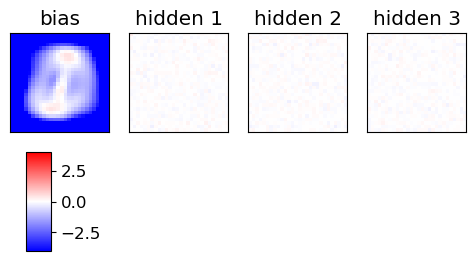

100%|██████████| 150/150 [01:05<00:00,  2.28it/s]


<Figure size 640x480 with 0 Axes>

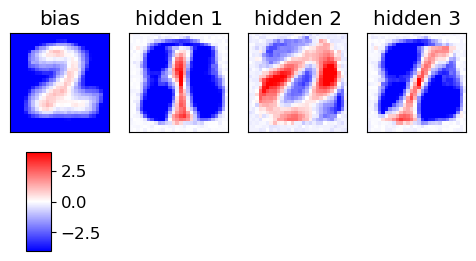

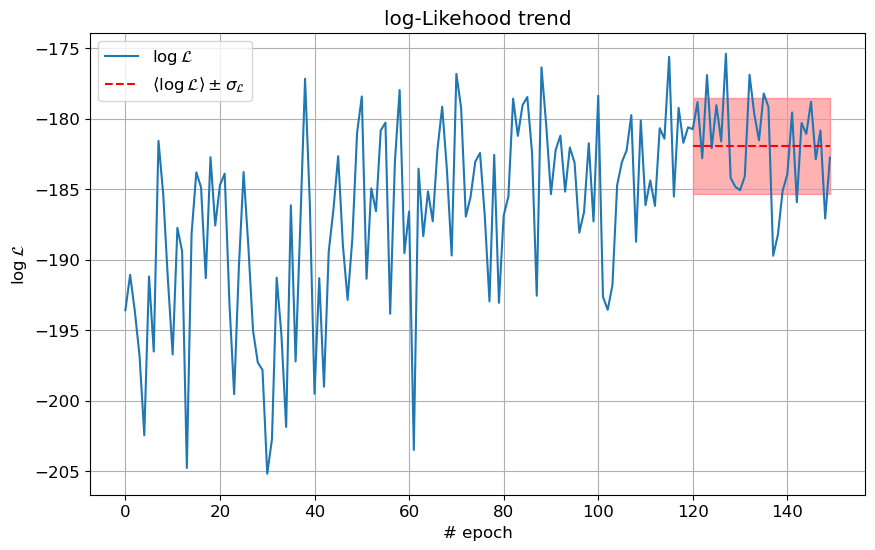

In [109]:
Folder1 = "kfolds_default_hp"
!mkdir $Folder1
DefaultHyperp = {'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}
print(DefaultHyperp)
LLmean, LLstd = train_RBM(DefaultHyperp, FolderName = Folder1, Debug = True, LL = True, LLPlot=True, BoolSaveFile=True)

### Default model (k-folds)

In [114]:
Folder2 = "kfolds_default_hp2"
!mkdir $Folder2
DefaultHyperp = {'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 100, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

In [115]:
#PERFORM THE K-FOLD
logLtrain_arrays,logLvalid_arrays = KFold_SingleModel(data, DefaultHyperp, num_k_folds = 3 , FolderToSave = Folder2)

mkdir: kfolds_default_hp2: File exists


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


In [121]:
#USE THIS WHEN K FOLDS IS ALREADY STORED
logLtrain_arrays = LoadArrays('logL', DefaultHyperp, Folder2)
logLvalid_arrays = LoadArrays('logL_Valid', DefaultHyperp, Folder2)

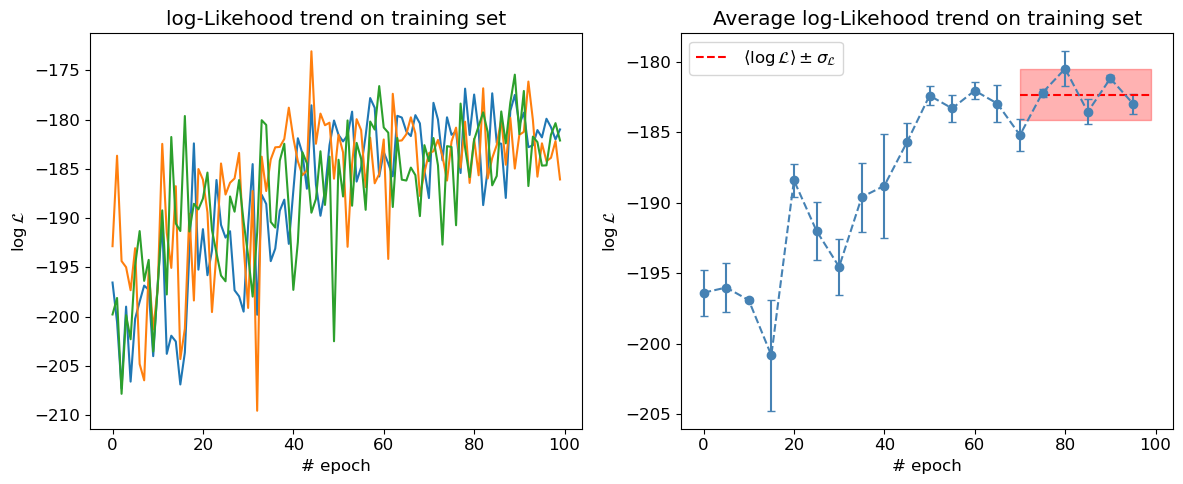

In [122]:
plot_LogL_sameHP(logLtrain_arrays,"training",epoch_step_ticker=5)

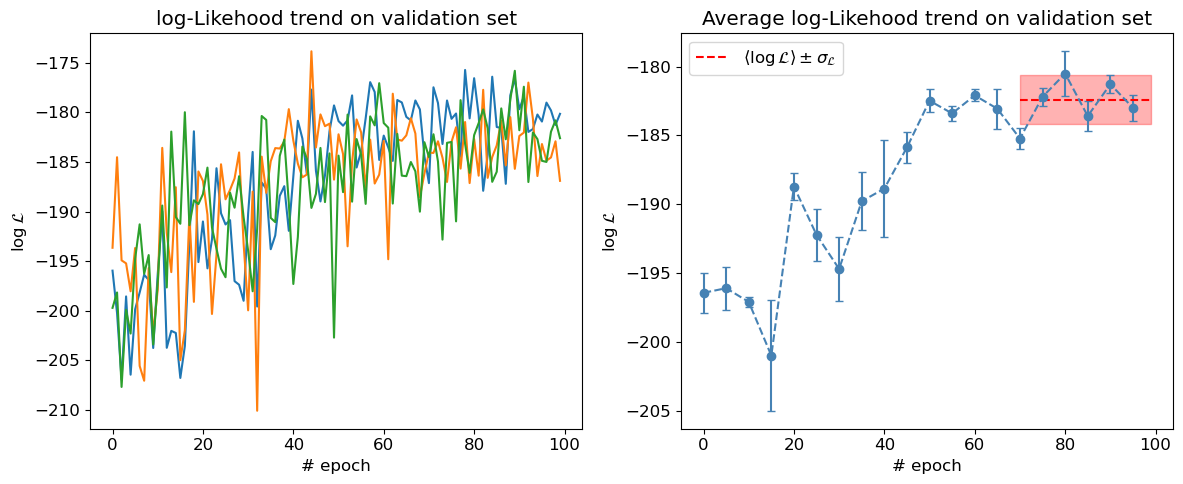

In [123]:
plot_LogL_sameHP(logLvalid_arrays,"validation", epoch_step_ticker=5)

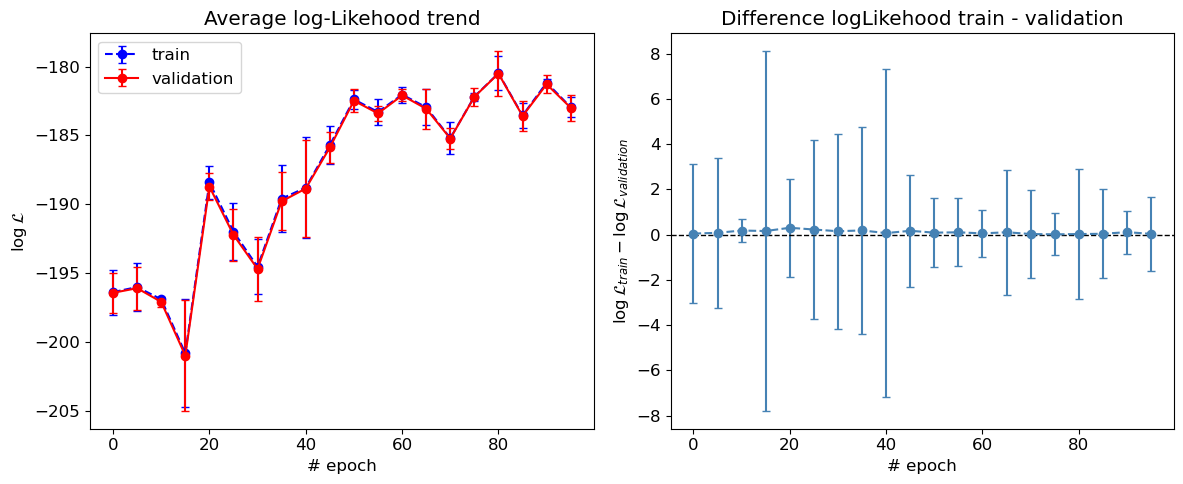

In [124]:
plot_LogL_trainVSvalid(logLtrain_arrays,logLvalid_arrays,epoch_step_ticker=5)

### Verify how $\mathcal{L}$ changes with L and CD

In [4]:
TestHyperp = {'Ndigit': 3, 'L': 3, 'Nt': 2, 
                 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 175, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

L_range = [1, 2, 3, 4, 5, 6, 7]
Nt_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


#Run time: 6hr
# TestLogLik, stdLL = np.zeros((len(L_range), len(Nt_range))), np.zeros((len(L_range), len(Nt_range)))

# for i, l in enumerate(L_range):
#    for j, nt in enumerate(Nt_range):
#       TestHyperp.update({'L': l, 'Nt': nt})
#       LLMean, LLstd = train_RBM(TestHyperp, data, 'TestTrain', Debug = False, LL = True, LLPlot = False, BoolSaveFile=True)
#       TestLogLik[i][j] = LLMean
#       stdLL[i][j] = LLstd

# np.save('TestLogLik1.npy', TestLogLik)
# np.save('stdLL1.npy', stdLL)

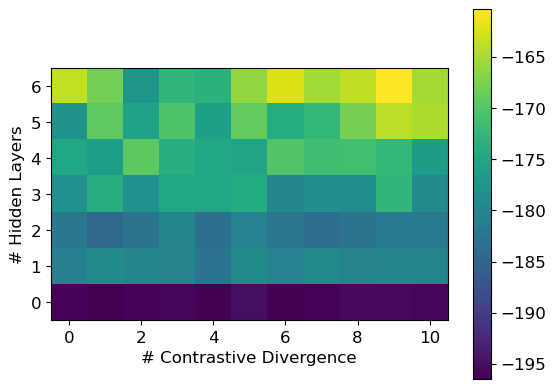

In [7]:
TestLogLik = np.load('TestLogLik1.npy')
stdLL = np.load('stdLL1.npy')

#print(stdLL)

plt.imshow(TestLogLik)
plt.gca().invert_yaxis()
plt.colorbar()

x, y = np.meshgrid(np.arange(2), np.arange(2))
#plt.scatter(x, y, color='white', s=10)  # Small dots at each point
#plt.errorbar(x.ravel(), y.ravel(), yerr=stdLL.ravel(), fmt='none', ecolor='white', alpha=0.8)
#plt.xticks(ticks=np.arange(0, len(Nt_range)), labels=np.arange(2, len(L_range) + 2))
#plt.yticks(ticks=np.arange(0, len(L_range)), labels=np.arange(1, len(L_range) + 1))
plt.xlabel("# Contrastive Divergence")
plt.ylabel("# Hidden Layers")

plt.show()

# 2. Testing RBM

### Test generative power of the trained RBM

In [46]:
aE = LoadData('a', 'SingleTrain')

list(aE.values())[0]

IndexError: list index out of range

In [47]:
#Loading all the file in the folder and, from all, take the last one (chronologically)
aE = list(LoadData('a', 'SingleTrain').values())[-1]
bE = list(LoadData('b', 'SingleTrain').values())[-1]
wE = list(LoadData('w', 'SingleTrain').values())[-1]

ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=10.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)

plot_weights_bias(wE, aE, 150, L, cols=3, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF )

IndexError: list index out of range

### Plot of the gradient amplitude (DA SISTEMARE LA FUNZIONE TRAIN DA METTERE UN PARAMETRO FLAG DI INPUT "GradientData" CHE SE È TRUE ALLORA VENGONO SALVATI NEI FILE ANCHE gwE gaE gbE che servono per fare quel plottino bello bello di Baiesi)

In [165]:
NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_8586/614569599.py:24: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
/tmp/ipykernel_8586/614569599.py:24: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)


NameError: name 'gwE' is not defined

# 3. Hyperparameters

### Implementing Random Search

In [77]:
Folder4 = 'BM_RandomSearch'
!mkdir $Folder4

HP_range = {'Ndig': 3,
      'L': [3, 6], 
      'Nt': [2, 6], 
      'Opt': ['RMSprop', 'SGD'],
      'l_rate_in': [1, 0.1], 
      'l_rate_fin': [0.1, 0.05],  'mini': [10, 41],'gamma': [0.1, 0.001],'epochs' : 100}
      #'BERN','POTTS','SPINS' is decided inside the RandomSearch function}

def RandomSearch(HP_range, nModels):

   HyperParams_List = []

   for _ in range(nModels):

      Ndigit = HP_range['Ndig']
      L = np.random.randint(HP_range['L'][0], HP_range['L'][1])
      Nt = np.random.randint(HP_range['Nt'][0], HP_range['Nt'][1] )
      l_rate_in = np.round(np.random.uniform(HP_range['l_rate_in'][0], HP_range['l_rate_in'][1]), 4)
      l_rate_fin = np.round(np.random.uniform(HP_range['l_rate_fin'][0], HP_range['l_rate_fin'][1]), 4)
      mini = np.random.choice(range(HP_range['mini'][0], HP_range['mini'][1], 5))
      gamma = np.round(np.random.uniform(HP_range['gamma'][0], HP_range['gamma'][1]), 4)
      epochs = HP_range['epochs']
      Opt = np.random.choice(HP_range['Opt'])
      Met = np.random.choice(['BERN','POTTS','SPINS'])

      HyperParams = {'Ndigit': Ndigit, 'L': L, 'Nt': Nt, 'Opt': Opt, 'l_rate_in': l_rate_in, 
                     'l_rate_fin': l_rate_fin, 'epochs': epochs, 'mini': mini, 'gamma': gamma, 'POTTS': False, 'SPINS': False}

      if Met == 'BERN':
            HyperParams['POTTS'] = False
            HyperParams['SPINS'] = False
      if Met == 'POTTS':
            HyperParams['POTTS'] = True
            HyperParams['SPINS'] = False
      if Met == 'SPINS':
            HyperParams['POTTS'] = False
            HyperParams['SPINS'] = True

      HyperParams_List.append(HyperParams)

   return HyperParams_List

mkdir: BM_RandomSearch: File exists


### Training with all the Models

In [88]:
HyperParam_List = np.array( RandomSearch(HP_range, nModels = 1) )
HyperParam_List #to check everything is fine

array([{'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'SGD', 'l_rate_in': 0.3333, 'l_rate_fin': 0.0533, 'epochs': 100, 'mini': 40, 'gamma': 0.0474, 'POTTS': True, 'SPINS': False}],
      dtype=object)

In [89]:
num_k_folds = 3

In [ ]:
ModelsLogsL = [] #e.g. [ modelA(arrays_logLtrain, arrays_logLvalidation) , modelB(arrays_logLtrain, arrays_logLvalidation) ]

for hp in HyperParam_List:
   arrays_logLtrain, arrays_logLvalidation = KFold_SingleModel(data, hp, num_k_folds=num_k_folds, FolderToSave=Folder4)
   ModelsLogsL.append( (arrays_logLtrain, arrays_logLvalidation) )

LastPartLogL = 3 #taking just the last numbers of data from the logLvalidation
ResultModels = [] #this has tuples of (mean,std) considering just the "LastPartLogL" number of data, where logL flattens
for LogsL_train,LogsL_valid in ModelsLogsL:
   mean_LogL_valid = np.mean(LogsL_valid, axis=0)
   ResultModels.append ((np.mean(mean_LogL_valid[ -LastPartLogL: ]) , np.std(mean_LogL_valid[ -LastPartLogL: ])  )       )

#needed cause later we'll sort them
ModelsLogsL = np.array(ModelsLogsL)
ResultModels = np.array(ResultModels)

mkdir: BM_RandomSearch: File exists


100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


In [ ]:
def OrderingModels(HyperParam_List, ResultModels, ModelsLogsL):
    sorted_indices = sorted(range(len(ResultModels)), key=lambda i: ResultModels[i][0], reverse=True) #array to sort the results accourdint to the FINAL_meanLogL chose (i.e. on validation and just the last LastPartLogL number of data)
    #sorted_indices = np.array(sorted_indices)
    return HyperParam_List[sorted_indices] , ResultModels[sorted_indices], ModelsLogsL[sorted_indices]

In [98]:
#Ordering the models according to the results
HyperParam_List, ResultModels, ModelsLogsL = OrderingModels(HyperParam_List, ResultModels, ModelsLogsL )

TopModels  = 1 #decide how many model to take
TopHP      = list(HyperParam_List[:2])
TopResults = list(ResultModels[:2])

#DataFrame to visualize the results
df = pd.DataFrame(TopHP)
df.index = [ f'Model {i+1}' for i in range(len(TopHP))] 
df[r"$\langle\mathcal{\log L}\rangle$"] = [res[0] for res in TopResults] #Final mean LogL
df[r"$\sigma_{\mathcal{L}}$"] = [res[1] for res in TopResults] #Final std LogL

# Display DataFrame
df

,Ndigit,L,Nt,Opt,l_rate_in,l_rate_fin,epochs,mini,gamma,POTTS,SPINS,$\langle\mathcal{\log L}\rangle$,$\sigma_{\mathcal{L}}$
Model 1,3,3,2,SGD,0.3333,0.0533,100,40,0.0474,True,False,-212.60598,0.020072


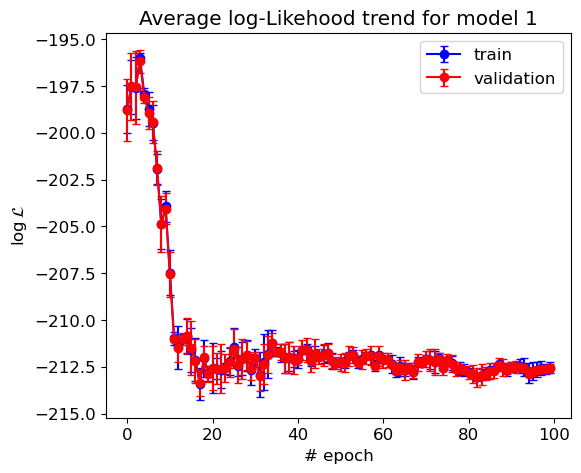

In [99]:
for i in range(TopModels):
    plot_LogL_model( ModelsLogsL[i][0], ModelsLogsL[i][1], Nmodel=i+1, epoch_step_ticker=1 ) #ModelsLogsL[i] = (arrays_logLtrain, arrays_logLvalidation)

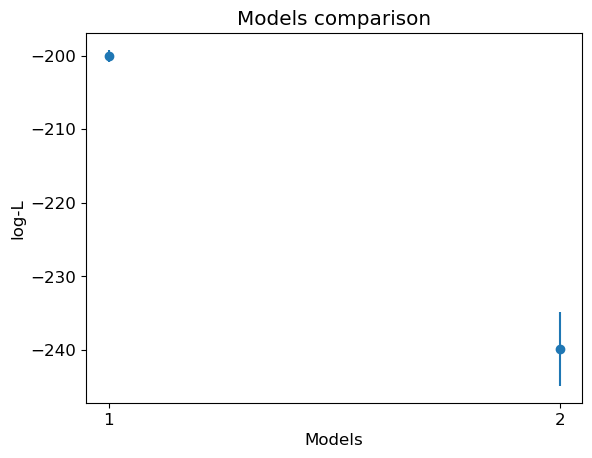

In [133]:
x = np.arange(len(TopHP))
y = [t[0] for t in TopResults]
erry = [t[1] for t in TopResults]

plt.errorbar(x, y, yerr = erry, fmt='o')
plt.ylabel("log-L")
plt.xlabel("Models")
plt.title("Models comparison")
plt.xticks(ticks=np.arange(0, len(x)), labels=np.arange(1, len(x)+1))
plt.show()

# 4. Hidden state activation

We want now to visualize the distribution of the activated hidden states. We firstly visualize for a simple RMB with just 3 digits (0, 1, 2) and only 3 hidden states. Then we visualize the same distribution but with all 10 numbers from the MNIST and 5 hidden states

In [ ]:
#I SUGGEST TO CREATE A FOLDER FOR THIS SECTION
Folder5 = "hidden_state_activation"
!mkdir $Folder5

In [ ]:
def HiddenStateAct(Nc, HyperP, aE, bE, wE, xAxis, ImSize, showGlobalHist = False):

    Ndigit = HyperP['Ndigit']
    L = HyperP['L']

    nRows = int(np.floor(Ndigit/3)*2) if showGlobalHist and Ndigit <= 3 else int(np.ceil(Ndigit/3))
    data, label = InitializeData(Ndigit)

    digits = [data[label == i] for i in range(Ndigit)] # "shape" (Ndigit, Ndata, 784)
    fig, axes = plt.subplots(nRows, 3, figsize=ImSize)

    z_Nf_freq = [] # z_Nf_freq has shape (N_digits, 2**L, L)

    states = list(map(lambda s: str(s).replace(",", "").replace("(", "[").replace(")", "]"), itertools.product([0, 1], repeat=L)))  # I need [0 0 0] format goddammit

    units_freq = np.zeros((Ndigit, L)) # each element is an array of frequencies for each unit composing the hidden state of dim. L

    # generalize to arbitrary number of plots

    for i in range(Ndigit):
        # x_cd = np.zeros((Nc, len(digits[i]), L))
        x_f = digits[i]          # shape (N, 784)
        z_cd = np.zeros((Nc, len(digits[i]), L))

        for j in range(Nc):
            z_cd[j] = [CD_step(digit, wE[-1], bE[-1]) for digit in x_f]
            x_f     = [CD_step(zeta, wE[-1].T, aE[-1]) for zeta in z_cd[j]]

        z_Nf_activated = [str(state).replace(".", "") for state in z_cd[-1]]

        z_Nf_occurrences = Counter(z_Nf_activated) # {(0,0,1): 4, (1,0,1): 10, ...}
        
        single_digit_frequencies = [z_Nf_occurrences[state] for state in states]
        z_Nf_freq.append(single_digit_frequencies)

        units_freq[i] = np.sum(z_cd[-1], axis=0)

    #####################################################
    # VISUALIZATION
    #####################################################

    if Ndigit > 3:
        digit = 0
        for t in range(nRows):
            for k in range(3):
                if (t*3)+k == Ndigit: break
                #axes[i].bar(states, z_0_frequencies, fill=False, hatch='.', edgecolor='purple', label=f'Activated by image')
                axes[t][k].bar(states, z_Nf_freq[(t*3)+k], fill=False, hatch='/', edgecolor='orange', label=f'Activated at step {Nc}')

                if xAxis == False: 
                    axes[t][k].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

                axes[t][k].title.set_text(f"Digit {digit} activated states")
                axes[t][k].legend()
                axes[t][k].set_xlabel("Possible States")
                axes[t][k].set_ylabel("Counts")

                digit += 1

    elif Ndigit <= 3 and showGlobalHist:

        units = ['$Z_1$', '$Z_2$', '$Z_3$']

        for i in range(3):
            #axes[i].bar(states, z_0_frequencies, fill=False, hatch='.', edgecolor='purple', label=f'Activated by image')
            axes[0][i].bar(states, z_Nf_freq[i], fill=False, hatch='/', edgecolor='orange', label= f'States activated at step {Nc}' if Nc > 1 else "States activated by images")
            axes[1][i].bar(units, units_freq[i], fill=False, hatch='/', edgecolor='blue', label= f'Units activated at step {Nc}' if Nc > 1 else "Units activated by images")
            
            for t in range(nRows):

                if xAxis == False: 
                    axes[t][i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

                axes[t][i].title.set_text(f"Digit {i}")
                axes[t][i].legend()
                axes[t][i].set_xlabel("Possible States")
                axes[t][i].set_ylabel("Counts")

    else:

        for i in range(3):
            #axes[i].bar(states, z_0_frequencies, fill=False, hatch='.', edgecolor='purple', label=f'Activated by image')
            axes[i].bar(states, z_Nf_freq[0][i], fill=False, hatch='/', edgecolor='orange', label= f'States activated at step {Nc}' if Nc > 1 else "States activated by images")

            if xAxis == False: 
                axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

            axes[i].title.set_text(f"Digit {i}")
            axes[i].legend()
            axes[i].set_xlabel("Possible States")
            axes[i].set_ylabel("Counts")

    fig.tight_layout()  # Automatically adjusts spacing
    plt.show()
    plt.close()

In [220]:
HiddenStateActHyperP1 = {'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

#train_RBM(HiddenStateActHyperP1, FolderName='TestTrain', Debug = False, LL = False, LLPlot=False, BoolSaveFile=True )

('0', '1', '2')
dataset with 21770 points, each with 784 bits



100%|██████████| 150/150 [00:40<00:00,  3.68it/s]


('0', '1', '2')
dataset with 21770 points, each with 784 bits



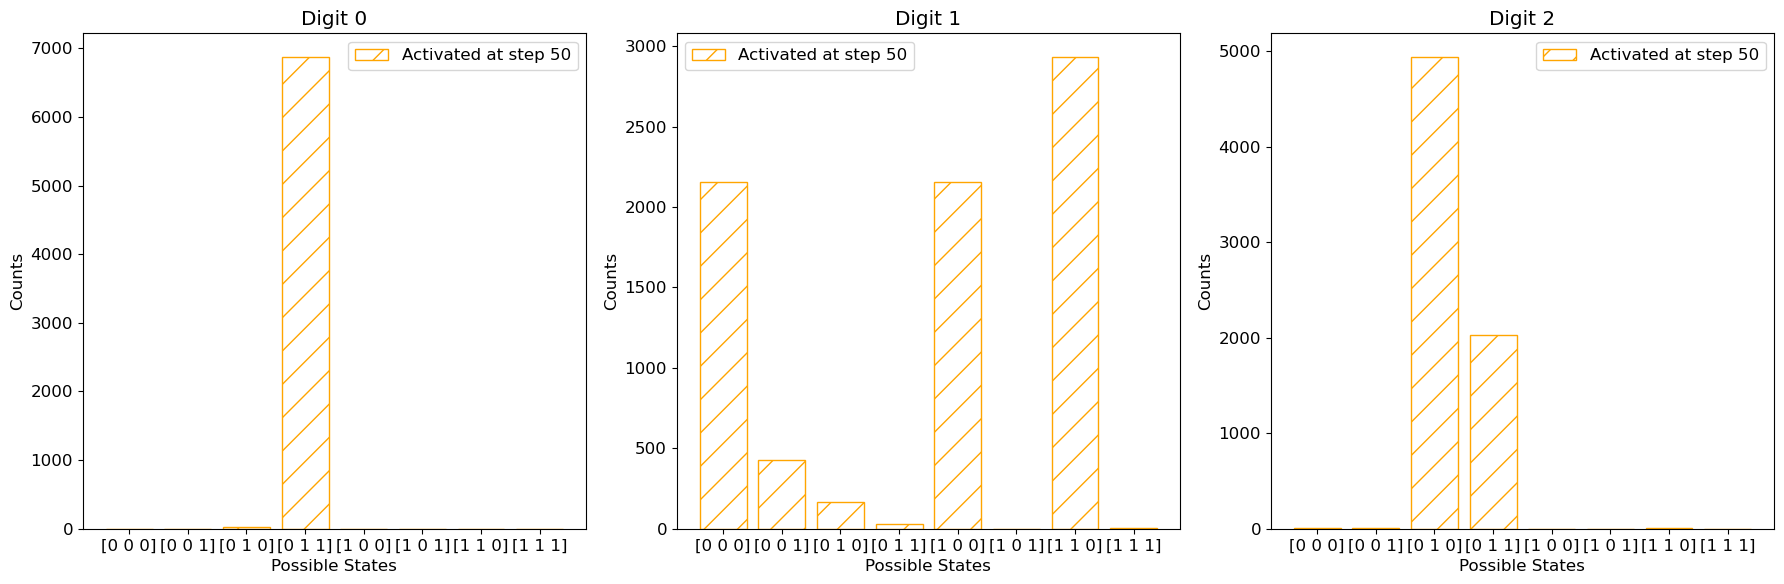

In [ ]:
#TO BE CHANGED THE FILENAME
#once you have the hyperparameters dictionarys (i.e. HiddenStateActHyperP1) should be easy
#se function    LoadArrays(what, hp, Folder)    in LoadData section
#Use the Folder5, see the beggining of this section

aE = np.load('TestTrain/a_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
bE = np.load('TestTrain/b_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
wE = np.load('TestTrain/w_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')

plot_weights_bias(wE, aE, 150, 3, cols=3, save=False)
HiddenStateAct(50, HiddenStateActHyperP1, aE, bE, wE, xAxis = True, ImSize = (18, 6))

And now for the bigger model:

In [ ]:
HiddenStateActHyperP2 = {'Ndigit': 9, 'L': 10, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

train_RBM(HiddenStateActHyperP2, FolderName='TestTrain', Debug = False, LL = False, LLPlot=False, BoolSaveFile=True )

('0', '1', '2', '3', '4', '5', '6', '7', '8')
dataset with 63042 points, each with 784 bits



100%|██████████| 150/150 [00:44<00:00,  3.39it/s]


('0', '1', '2', '3', '4', '5', '6', '7', '8')
dataset with 63042 points, each with 784 bits



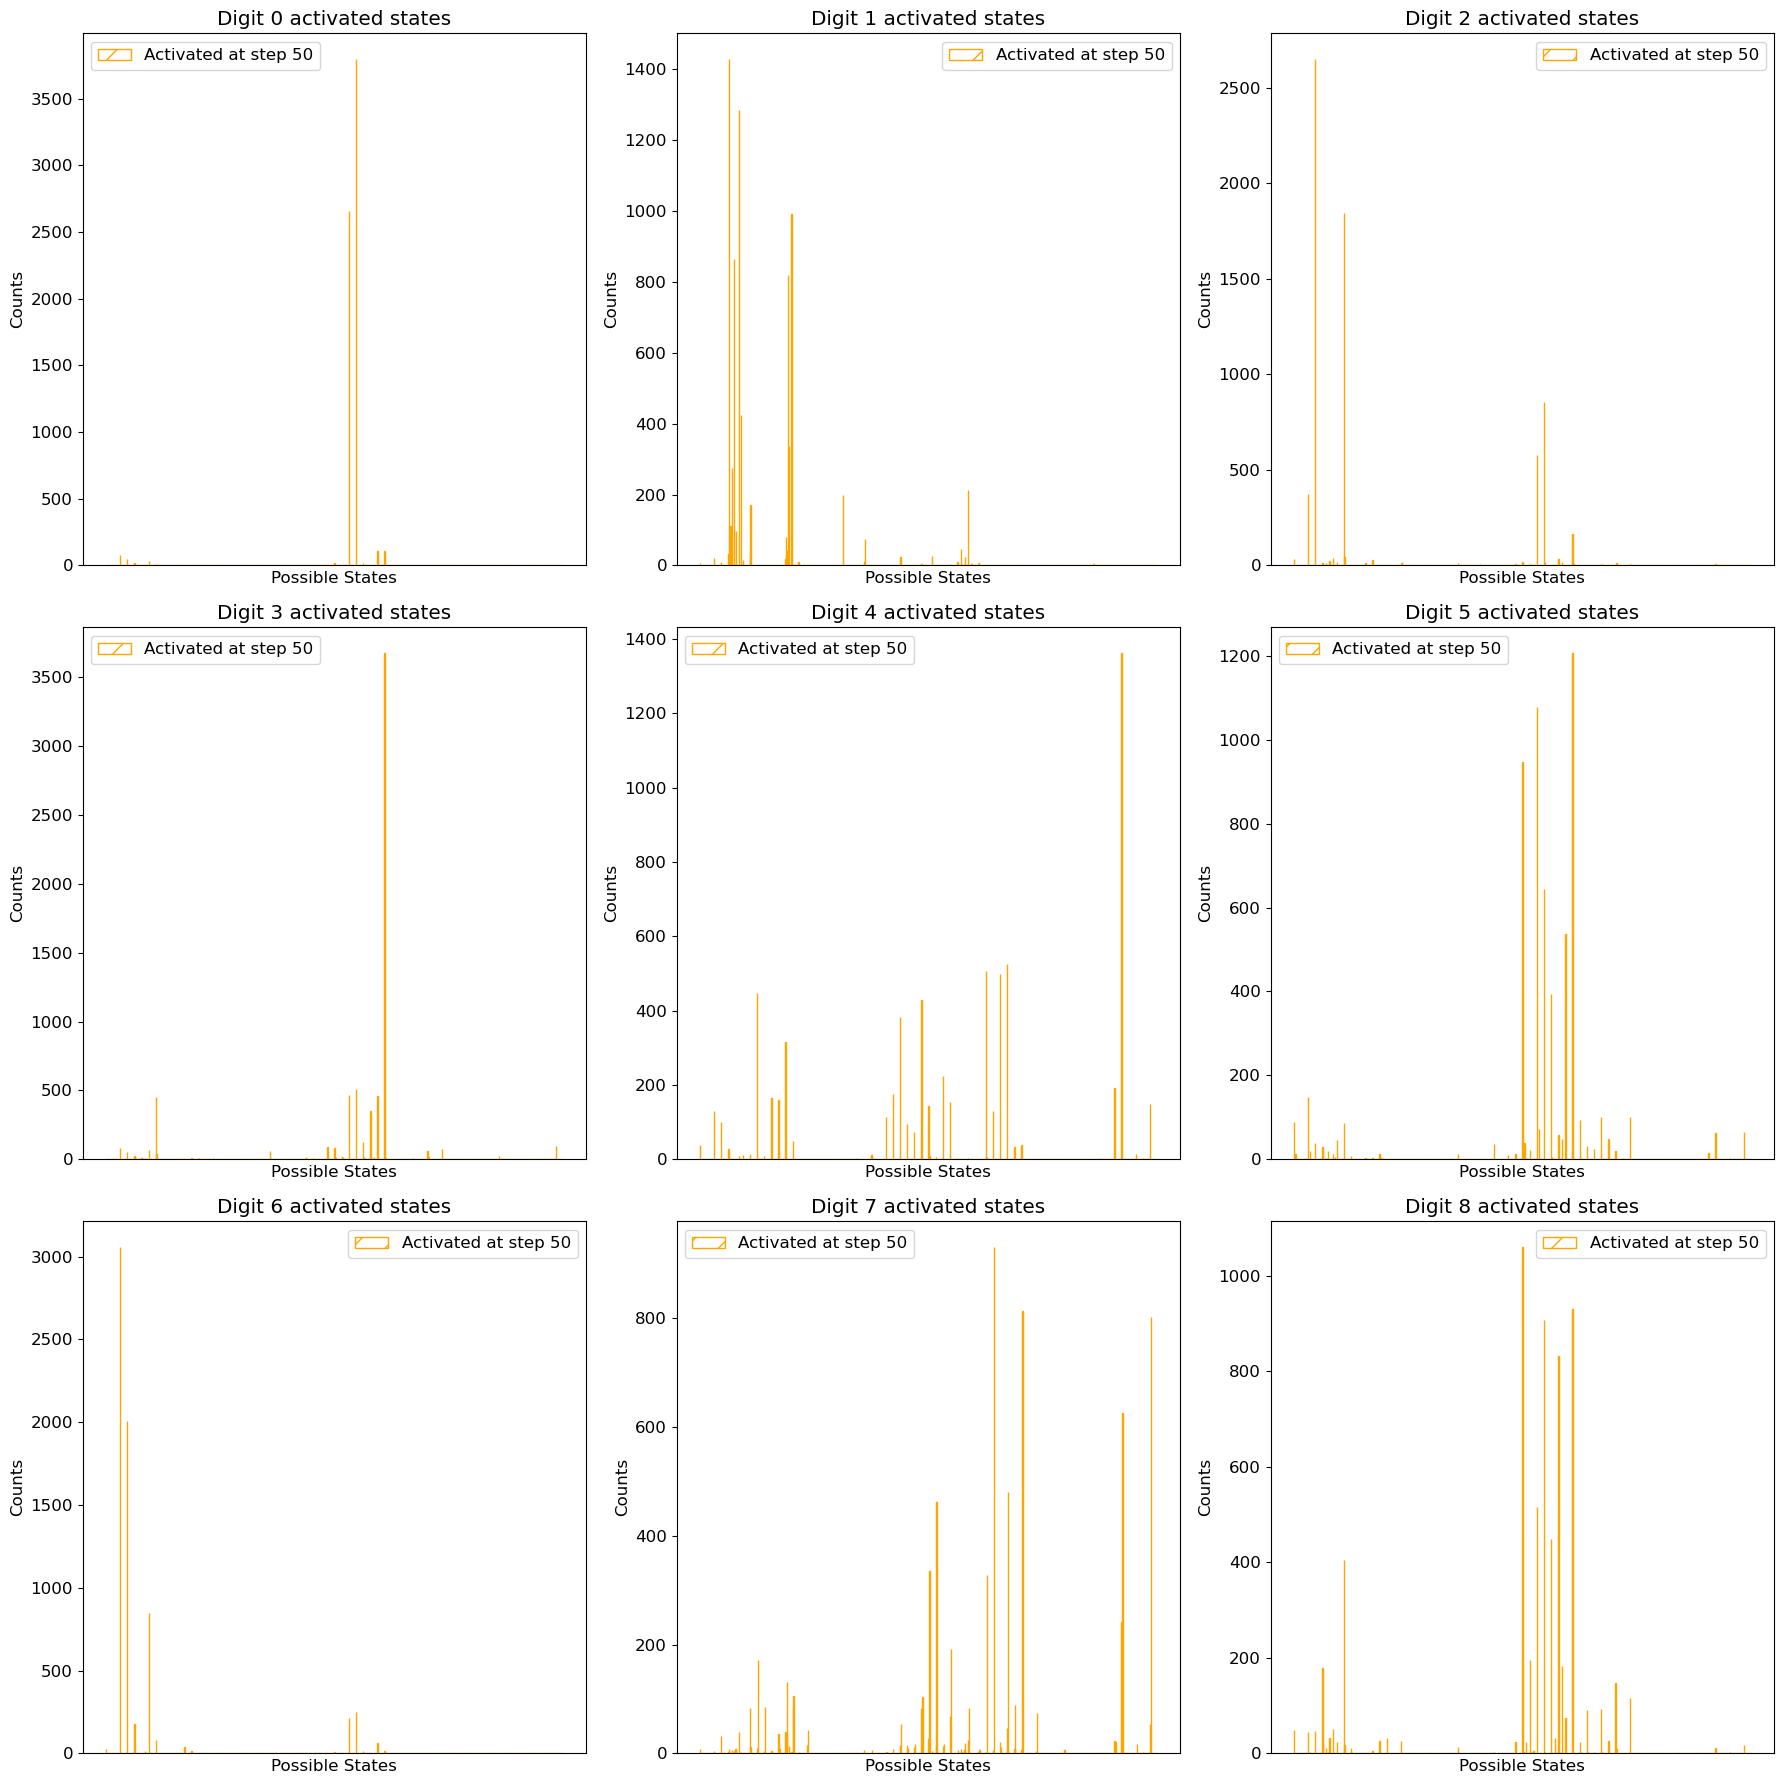

In [ ]:
#same as before see loaddata section LoadArrays(what, hp, Folder)


aE = np.load('TestTrain/a_RBM_9_10_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1832.npy')
bE = np.load('TestTrain/b_RBM_9_10_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1832.npy')
wE = np.load('TestTrain/w_RBM_9_10_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1832.npy')

plot_weights_bias(wE, aE, 150, 10, cols=5, save=False)
HiddenStateAct(50, HiddenStateActHyperP2, aE, bE, wE, xAxis = False, ImSize = (18, 18))

# 5. Energy barriers (do not run the code below, please. Otherwise we'll lost those graph)

We are still working on this part. Now we just show the presence of energy barriers in the RBM.

In [264]:
def EnergyBarrier(aE, bE, wE, ShowBarrier):
    W = wE[-1]
    a = aE[-1]
    b = bE[-1]

    selectA = 1
    selectB = 2
    index_selectA = np.random.choice( np.where(label == selectA)[0] )
    index_selectB = np.random.choice( np.where(label == selectB)[0] )
    dataA = data[index_selectA]
    dataB = data[index_selectB]

    zA = CD_step(dataA,W,b)
    zB = CD_step(dataB,W,b)

    def energy(x, z, W, a, b):
        return -(np.dot(x, a) + np.dot(z, b) + np.dot(x, np.dot(W , z)))

    n_steps = 150
    energies = []
    intermediate_images = []

    for alpha in np.linspace(0, 1, n_steps):

        if ShowBarrier:
            # PART SHOW BARRIER
            x_intermediate = (1 - alpha) * dataA + alpha * dataB  # Interpolazione lineare
            x_intermediate = (x_intermediate > 0.5).astype(int)  # Soglia binaria
            z_intermediate = CD_step(x_intermediate, W, b,)

            E = energy(x_intermediate, z_intermediate, W, a, b)
            energies.append(E)
            intermediate_images.append(x_intermediate.reshape(28, 28))
            # ----------------------

        else:
            # PART OVERCOME BARRIER
            x_intermediate = np.zeros(D)
            #ora per ogni pixel, decido con la soglia random se prendere il valore da dataA o da dataB
            for i in range(D):
                if np.random.uniform() > alpha:
                    x_intermediate[i] = dataA[i]
                else:
                    x_intermediate[i] = dataB[i]

                z_intermediate = CD_step(x_intermediate, W, b,)

            E = energy(x_intermediate, z_intermediate, W, a, b)
            energies.append(E)
            intermediate_images.append(x_intermediate.reshape(28, 28))



    plt.figure(figsize=(8, 4))
    plt.plot(range(n_steps), energies, marker='o')
    if ShowBarrier: plt.xlabel(f"Linear transition between {selectA} and {selectB}")
    else: plt.xlabel(f"Random transition between {selectA} and {selectB}")
    plt.ylabel("Energy")
    plt.title(f"Energetic barrier between {selectA} and {selectB}")
    plt.grid()
    plt.show()

    # show some intermediate step
    show_inter_steps = 5
    fig, axes = plt.subplots(1, show_inter_steps, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(intermediate_images[i * (n_steps // show_inter_steps)], cmap='gray')
        ax.axis('off')
    plt.show()
    

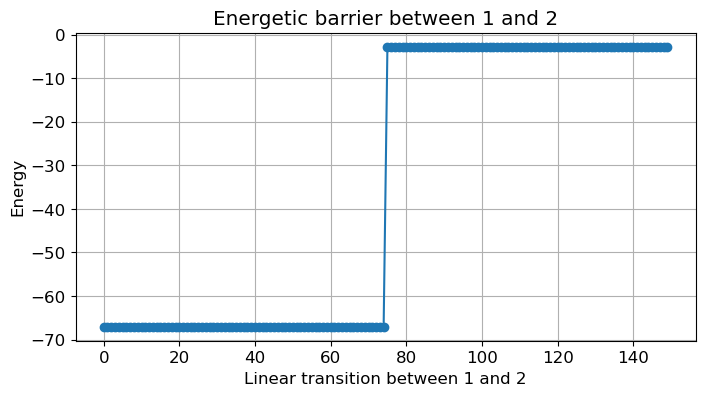

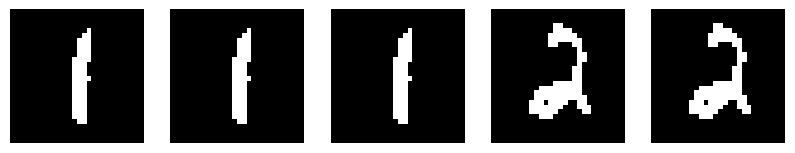

In [265]:
aE = np.load('TestTrain/a_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
bE = np.load('TestTrain/b_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
wE = np.load('TestTrain/w_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')

EnergyBarrier(aE, bE, wE, ShowBarrier=True)

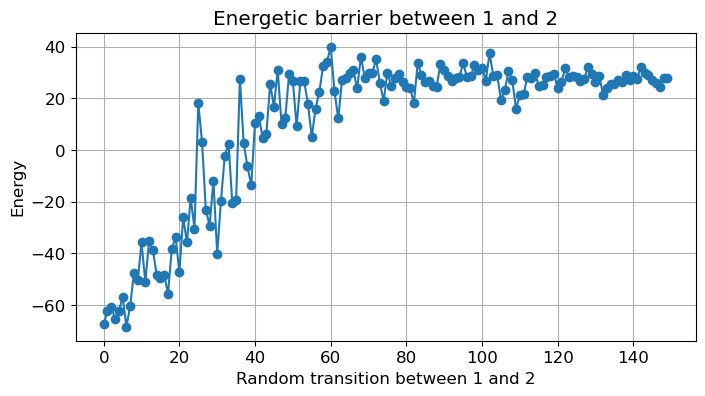

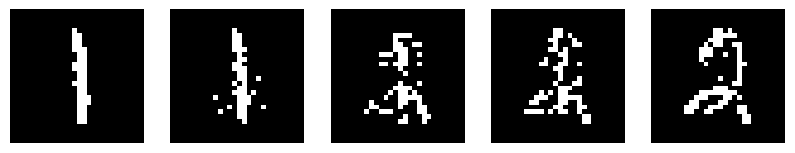

In [266]:
EnergyBarrier(aE, bE, wE, ShowBarrier=False)